### Project Description: Face Recognition using Principal Component Analysis (PCA)
This project aims to create a basic facial recognition system using Principal Component Analysis (PCA), a dimensionality reduction technique that projects face images onto a feature space called "face space." The face space is constructed by extracting the eigenvectors, or "Eigenfaces," from a set of training face images. These Eigenfaces capture the variations among distinct faces, representing the most significant features that differentiate individuals.

The system works by recognizing a person’s face from a pre-existing database. Given a new input image, the system compares it to the database and identifies the closest match based on how the input is projected in the face space.

### Steps Implemented in the Project:
1. Data Preparation:
- Used the AT&T face dataset with grayscale images (92x112 pixels) for 40 subjects, each with 10 images showing variations in lighting, facial expressions, and details.
- The dataset was used for both training and testing.
2. Feature Extraction using PCA:
- Applied PCA to extract "Eigenfaces" from the images, representing the key variations in the dataset.
- Images were reshaped into vectors, centered by subtracting the mean face, and projected onto the lower-dimensional face space formed by the Eigenfaces.
3. Training the Recognition System:
- Projected face images onto the face space and stored the projections as compact representations of each subject.
Face Recognition:
4. For a new input image, projected it onto the face space.
- Compared its projection with known faces using Euclidean distance to identify the closest match.
Results and Evaluation:
5. Split the dataset into training and test sets.
- Evaluated recognition accuracy by comparing test images to the trained model, with PCA providing a robust solution to face recognition under various conditions.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Tasks
1. Load dataset and divide the date into training and test sets.
2. Implement the PCA algorithm from scratch.
3. Implement image reconstruction using the eigen projections and visualise differences for different number of components.
4. Visualise the mean(Eigen face) generated.
5. Given training set, obtain accuracy by attempting a face regonition module and obtaining the accuracy for different number of principal components.

#### Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from copy import copy
from tqdm import tqdm

#### Import Dataset
Assign labels for the images based on the subdirectories to obtain X(images array) and y (labels).

Ensure that the test data contains atleast one image from each category.

In [3]:
#1 iterate through all folders, load each image

trainAmt = 0.9
allFaces = []
labels = []
folder_path = "/content/drive/MyDrive/ATnT"
for i in range(1,41):
    for j in range(1,11):
        imgPath = os.path.join(folder_path, "s" + str(i), str(j) + ".pgm")
        img = cv2.imread(imgPath, -1)

        allFaces.append(img)
        labels.append(i)

# shuffle
randomOrder = np.random.permutation(len(labels))
allFaces = np.array(allFaces)[randomOrder]
labels = np.array(labels)[randomOrder]

# split
trainFaces = allFaces[:int(trainAmt*len(allFaces))]
trainLabels = labels[:int(trainAmt*len(allFaces))]

testFaces = allFaces[int(trainAmt*len(allFaces)): ]
testLabels = labels[int(trainAmt*len(allFaces)): ]

# 112x92 (= 10304) grayscale images,  360 in train, 40 in test
print(trainFaces.shape, trainLabels.shape)

(360, 112, 92) (360,)


#### Implement PCA Algorithm.

Explain your steps with comments and write a brief explanation of the method.

In [4]:
def principalComponentAnalysis(X, numComponents):
    """
    Implement pca in the following function by taking the following arguements:
    1. X(images array)
    2. number of components
    The function must return the eigen vectors (principal components) also termed "Eigen faces"
    """

    # Calculate mean face
    meanFace = np.mean(X, axis=0)

    # Subtract mean face from all faces
    X_centered = X - meanFace

    # Compute covariance matrix
    covariance_matrix = np.dot(X_centered.T, X_centered) / len(X_centered)

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Sort eigenvectors based on eigenvalues
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # Select the top 'numComponents' eigenvectors
    selected_eigenvectors = sorted_eigenvectors[:, :numComponents]

    return selected_eigenvectors, meanFace

In [5]:
def plotEigenFaces(eigenFaces, num_cols=5):
    num_faces = eigenFaces.shape[1]
    num_rows = num_faces // num_cols + (1 if num_faces % num_cols != 0 else 0)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i in range(num_rows):
        for j in range(num_cols):
            idx = i * num_cols + j
            if idx < num_faces:
                axes[i, j].imshow(eigenFaces[:, idx].reshape(112, 92), cmap='gray')
                axes[i, j].axis('off')
                axes[i, j].set_title(f'Eigenface {idx+1}')
            else:
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()



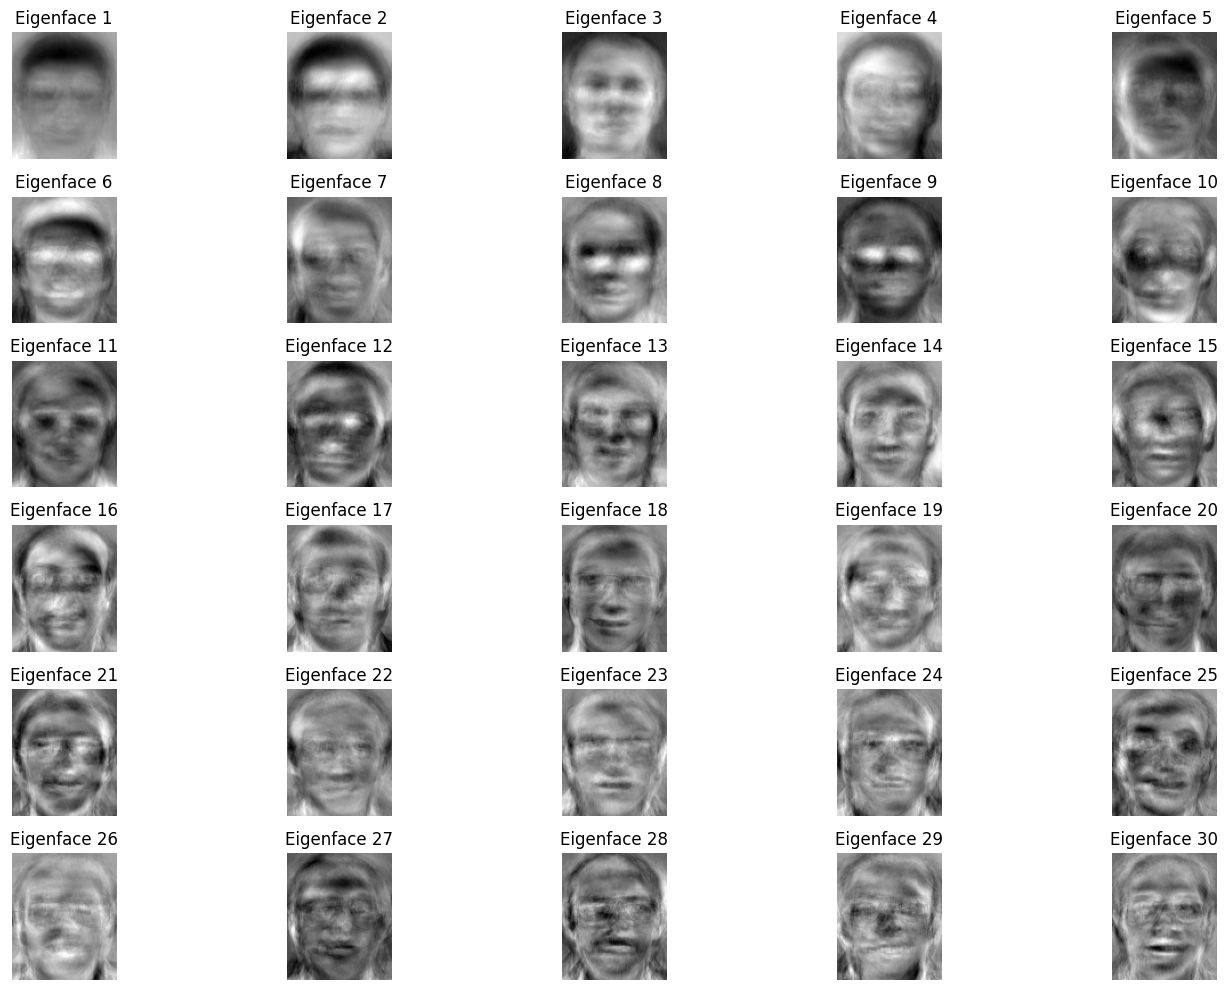

In [6]:
# Calculate eigenfaces and meanface
eigen_faces, mean_face = principalComponentAnalysis(trainFaces.reshape(-1, 10304), numComponents=30)
plotEigenFaces(eigen_faces)


#### Implement Image Reconstruction from Eigenfaces


Explain your steps with comments and write a brief explanation of the method.

In [7]:
def imageReconstruction(testFace, eigenFaces, meanFace):
    """
    Helper function to reconstruct images
    """

    # Flatten test face
    testFace_flattened = testFace.flatten()

    # Subtract mean face from test face
    testFace_centered = testFace_flattened - meanFace

    # Compute projection coefficients
    projection_coefficients = np.dot(testFace_centered, eigenFaces)

    # Reconstruct face using selected eigenfaces
    reconstructed_face = meanFace + np.dot(projection_coefficients, eigenFaces.T)

    return reconstructed_face.reshape(testFace.shape)

In [8]:
def plotReconstructions(testFace, eigenFaces, meanFace, numComponents_list):
    num_cols = len(numComponents_list) + 1
    num_rows = 1

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5))

    axes[0].imshow(testFace, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    for i, numComponents in enumerate(numComponents_list):
        reconstructed_face = imageReconstruction(testFace, eigenFaces[:, :numComponents], meanFace)
        axes[i+1].imshow(reconstructed_face, cmap='gray')
        axes[i+1].set_title(f'{numComponents} Components')
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()


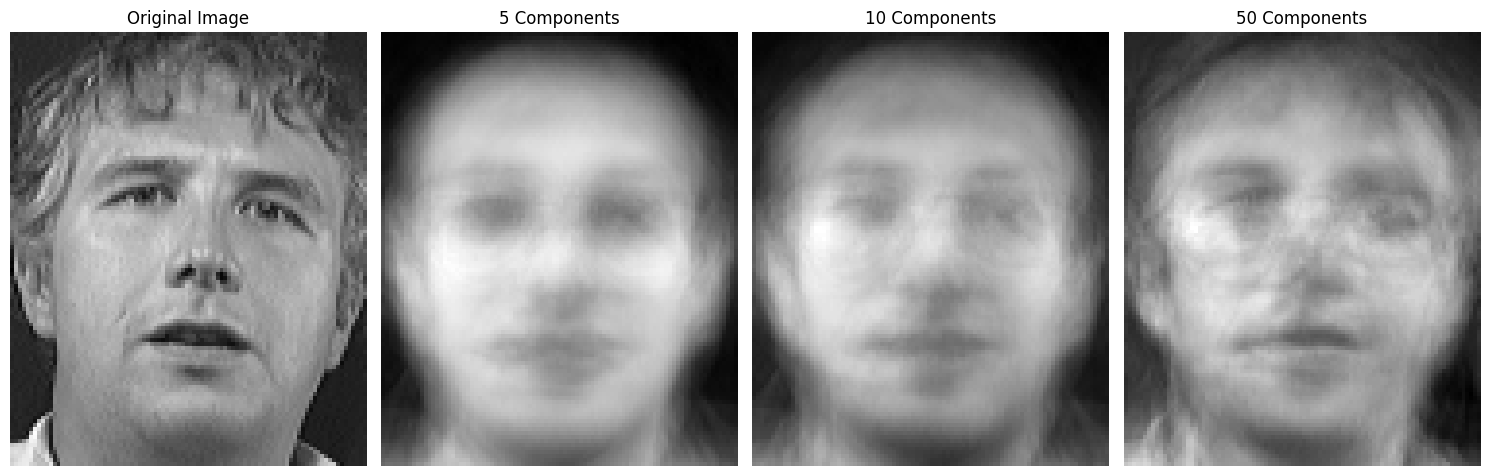

In [9]:
# plot recontructions here
%matplotlib inline


testFace = trainFaces[0]
numComponents_list = [5, 10, 50]
plotReconstructions(testFace, eigen_faces, mean_face, numComponents_list)


#### Visualisation
Visualise the results for different number of factors(pc = 5, 10, 50, 100, etc.)

**Note:** Ensure that the images are labelled appropriately.

In [10]:
%matplotlib inline

def displayNfactors(testFace, eigenFaces, meanFace, numComponents_list):
    fig, axes = plt.subplots(1, len(numComponents_list)+1, figsize=(20, 5))
    axes[0].imshow(meanFace.reshape(testFace.shape), cmap='gray')
    axes[0].set_title('Mean Face')

    for i, numComponents in enumerate(numComponents_list):
        reconstructed_face = imageReconstruction(testFace, eigenFaces[:, :numComponents], meanFace)
        axes[i+1].imshow(reconstructed_face, cmap='gray')
        axes[i+1].set_title(f'{numComponents} Components')

    plt.show()

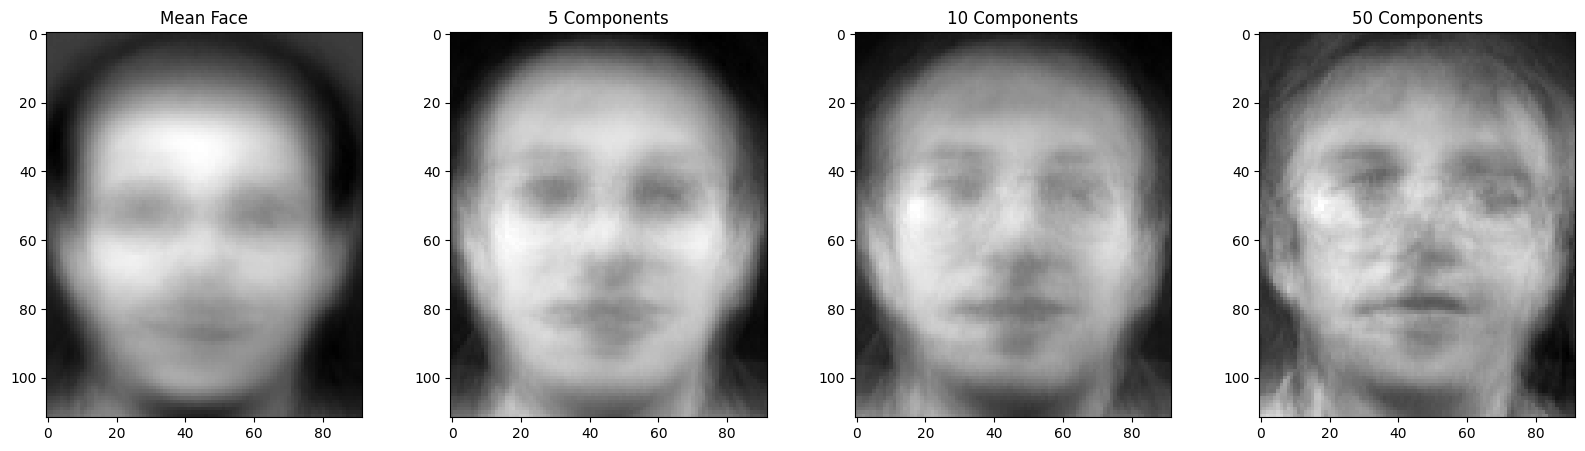

In [11]:
displayNfactors(testFace, eigen_faces, mean_face, numComponents_list)

#### Implement face recognition module based on the norm
Explain your steps with comments and write a brief explanation of the method.

*   Test the module and report accuracies based on the number of components taken for a range of value and plot them.
*   Also plot the mean square error vs the number of eigenvectors taken and report your observations.
*   For further empirical analysis, plot the semi-log variant of the error plot obtained above.

In [12]:
def getClass(testImage, eigenFaces, meanFace, X_train, y_train):
    """
    Arguments:
    1. Test image
    2. Eigenvectors
    3. Mean Eigen Face
    4. Training Set(X_train,y_train)

    Returns:
    1. closest_image: The image from the training set with the smallest reconstruction error.
    2. min_error: The smallest reconstruction error found.
    3. predicted_class: The predicted class label for the test image.
    """

    min_error = float('inf')
    predicted_class = None
    closest_image = None

    for i in range(len(X_train)):
        # Reconstruct the test image using eigenfaces
        reconstructed_face = imageReconstruction(testImage, eigenFaces, meanFace)

        # Compute the L2 norm (Euclidean distance) between the reconstructed face and each training face
        error = np.linalg.norm(reconstructed_face - X_train[i])

        # Update minimum error and predicted class if the current error is smaller
        if error < min_error:
            min_error = error
            predicted_class = y_train[i]
            closest_image = X_train[i]

    return closest_image, min_error, predicted_class

Iterate through all the images in the test data and test the accuracy by taking different number of components

Accuracy with 5 components: 0.55
Accuracy with 10 components: 0.9
Accuracy with 15 components: 0.95
Accuracy with 20 components: 0.975
Accuracy with 25 components: 1.0
Accuracy with 30 components: 1.0
Accuracy with 35 components: 1.0
Accuracy with 40 components: 1.0


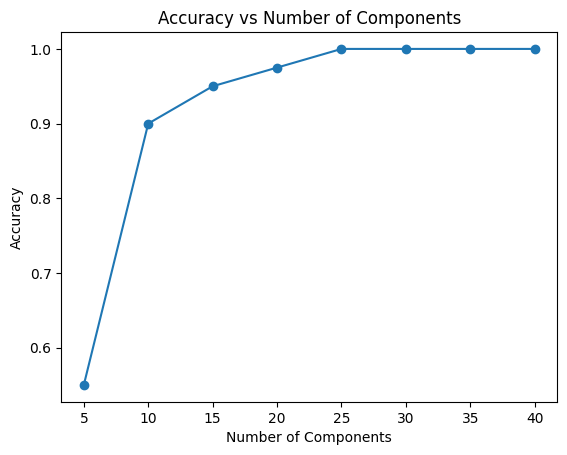

In [16]:
import matplotlib.pyplot as plt

components = [5, 10, 15, 20, 25, 30, 35, 40]
accuracies = []
error_images_dict = {num_components: [] for num_components in components}

for numComponents in components:
    correct_predictions = 0
    min_error = float('inf')
    min_error_image = None
    min_error_label = None

    for i in range(len(testFaces)):
        closest_image, error, predicted_class = getClass(testFaces[i], eigen_faces[:, :numComponents], mean_face, trainFaces, trainLabels)
        error_images_dict[numComponents].append((closest_image, error))

        if predicted_class == testLabels[i]:
            correct_predictions += 1

    accuracy = correct_predictions / len(testFaces)
    accuracies.append(accuracy)


    print(f'Accuracy with {numComponents} components: {accuracy}')

# Plot accuracies
plt.plot(components, accuracies, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Components')
plt.show()

Plot Number of eigenvectors vs Mean Square Error

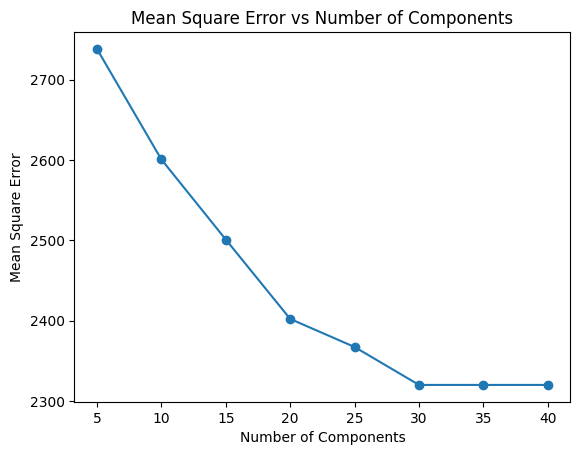

In [17]:
mse = []

for numComponents in components:
    errors = []
    for i in range(len(testFaces)):
        img, error, _ = getClass(testFaces[i], eigen_faces[:, :numComponents], mean_face, trainFaces, trainLabels)
        errors.append(error)
    mse.append(np.mean(errors))

# Plot mean square error
plt.plot(components, mse, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Mean Square Error')
plt.title('Mean Square Error vs Number of Components')
plt.show()




Plot Number of eigenvectors vs Logarithmic Mean Square Error

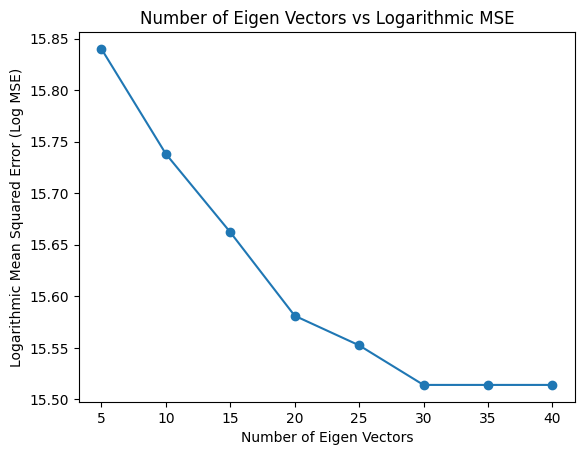

In [18]:
# Calculate Logarithmic Mean Square Error (Log MSE) for each number of eigen vectors
log_mse = []
for numComponents in components:
    total_error = 0
    for _, error in error_images_dict[numComponents]:
        total_error += error ** 2
    mean_squared_error = total_error / len(testFaces)
    log_mean_squared_error = np.log(mean_squared_error)  # Compute logarithm of the MSE
    log_mse.append(log_mean_squared_error)

# Plot number of eigen vectors vs Logarithmic MSE
plt.plot(components, log_mse, marker='o')
plt.xlabel('Number of Eigen Vectors')
plt.ylabel('Logarithmic Mean Squared Error (Log MSE)')
plt.title('Number of Eigen Vectors vs Logarithmic MSE')
plt.show()

### Observation
As the number of eigenvectors(PCA) increases, the mean square error (MSE) reduces because more eigenvectors capture more variance (information) from the original data. With fewer eigenvectors, only the most prominent features are represented, leading to higher reconstruction error. Adding more eigenvectors improves the accuracy of the reconstruction by capturing finer details, thereby reducing the difference between the original and reconstructed images, and lowering the MSE.